In [2]:
import sys, os, glob, h5py
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf

In [4]:
## MB Results come from fitting a temperature scan at a specified RF power
MB_fit_vals = np.array([4.24216+9.75e-6, 
                        0.177  ,
                        0.0125 ,
                        4.1e7  ]) ## [ F0 [GHz] , Delta , alpha , Qi0 ]

In [5]:
base_path = '/data/USRP_Noise_Scans'

In [6]:
## Find all the uncleaned files that correspond to a specific timestream acquisition
def GetFiles(series, verbose=False):
    data_path = os.path.join(base_path,series.split('_')[0],series)
    
    ## Grab the file with no calibration offset
    file_list = np.sort(glob.glob(data_path+"/*.h5"))

    s_file  = "None"
    d_file  = "None"
    v_file  = "None"
    t_files = []

    for file in file_list:

        if "Delay" in file:
            d_file = file

        if "VNA" in file:
            v_file = file

        if "noise_averages" in file:
            s_file = file

        if "delta" in file and not "cleaned" in file:
            t_files = np.append(t_files, file)

    if verbose:
        print("Line Delay file: ",d_file)
        print("VNA scan file:   ",v_file)
        print("Timestream files:",t_files)
        print("Summary file:    ",s_file)
        
    return s_file, d_file, v_file, t_files

In [7]:
## Pull metadata from the noise averages summary file, store in dictionary
def UnpackSummary(s_file_path, verbose=False):
    
    ## Open the summary file in read-only mode
    fsum = h5py.File(s_file_path, 'r')
    if verbose:
        print(fsum.keys())
        print(fsum.attrs.keys())
        
    ## Should only be one power per file
    ## Open that data member
    md   = fsum['Power0']
    if verbose:
        print(md.keys())
        print(md.attrs.keys())
        
    ## Create a dictionary to store results
    md_dict = {}
    
    ## Pull the metadata from the file into a dictionary
    for k in md.attrs.keys():
        md_dict[k] = md.attrs[k]
        
    ## Pull the mean F,S21 from the cal delta scans
    mean_frqs = np.copy(np.array(md['freqs']))
    mean_S21s = np.copy(np.array(md['means']))
    
    ## Close the summary h5 file
    fsum.close()

    return md_dict, mean_frqs, mean_S21s

In [8]:
def logMag(z):
    return np.log10( np.abs(z) )

def phase(z):
    return np.angle(z)

def timesFromRate(rate, length):
    ## rate passed in "samples per second"
    ## length is the number of points in array
    f = 1./rate
    times = np.arange(start=0, stop=f*(length), step=f)
    return times

In [9]:
series_list = np.array([
    "20220526_153840" , 
    "20220526_154021" , 
    "20220526_154151" , 
    "20220526_154322" , 
    "20220526_155108" , 
    "20220526_155237" , 
    "20220526_155408" , 
    "20220526_155540" , 
    "20220526_155708" , 
    "20220526_155837" 
])

P_min = -70 ; P_max = -25 ; P_step = 5
powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)

In [17]:
for i in np.arange(len(series_list)):
    print(series_list[i], ":", powers_list[i], "dBc")

20220526_153840 : -25 dBc
20220526_154021 : -30 dBc
20220526_154151 : -35 dBc
20220526_154322 : -40 dBc
20220526_155108 : -45 dBc
20220526_155237 : -50 dBc
20220526_155408 : -55 dBc
20220526_155540 : -60 dBc
20220526_155708 : -65 dBc
20220526_155837 : -70 dBc


In [26]:
sum_file, dly_file, vna_file, tone_files = GetFiles(series_list[5], verbose=True)

Line Delay file:  /data/USRP_Noise_Scans/20220526/20220526_155237/USRP_Delay_20220526_155237.h5
VNA scan file:    /data/USRP_Noise_Scans/20220526/20220526_155237/USRP_VNA_20220526_155237.h5
Timestream files: ['/data/USRP_Noise_Scans/20220526/20220526_155237/USRP_Noise_20220526_155237_delta0.h5']
Summary file:     /data/USRP_Noise_Scans/20220526/20220526_155237/noise_averages_20220526_155237.h5


In [27]:
metadata, avg_frqs, avg_S21s = UnpackSummary(sum_file)

In [28]:
print(metadata)

{'LOfreq': 4250000000.0, 'N_power': 63.09573444801933, 'delay_ns': 860.0, 'power': -50, 'rate': 100000000.0, 'rx_gain': 17.0, 'tx_gain': 0}


In [29]:
def CleanPSDs(ts_file, vna_file, PSD_lo_f=1e2, PSD_hi_f=5e4, f_transient=0.3, charZs=None, charFs=None, MBresults=None):
    PSD_lo_f = int(PSD_lo_f)  ## chunk up to [Hz]
    PSD_hi_f = int(PSD_hi_f)  ## decimate down to  [Hz]
    
    if (f_transient > 1.0):
        f_transient = 0.3

    _, noise_info = PUf.unavg_noi(ts_file)
    noise_total_time = noise_info['time'][-1]
    noise_fs = 1./noise_info['sampling period']
    noise_readout_f = noise_info['search freqs'][0]

    num_chunks = int(noise_total_time*PSD_lo_f)
    noise_decimation = int(noise_fs/PSD_hi_f)

    print("Will separate data into ", num_chunks      , "chunks to achieve the requested", "{:.2e}".format(PSD_lo_f),' Hz low  end of the PSD')
    print("Additional decimation by", noise_decimation, "needed to achieve the requested", "{:.2e}".format(PSD_hi_f),' Hz high end of the PSD')

    p, P, r, t = Prf.PSDs_and_cleaning(ts_file, vna_file,
                                      extra_dec  = noise_decimation,
                                      num_chunks = num_chunks,
                                      blank_chunks = int(f_transient*num_chunks),
                                      removal_decimation = 1,
                                      char_zs = charZs,
                                      char_fs = charFs,
                                      MB_results = MBresults)
    return p, P, r, t ## powers, PSDs, res, timestreams

Will separate data into  1000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
Will convert to quasiparticle basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20220526/20220526_155237/USRP_Noise_20220526_155237_delta0.h5 because override=True!
found 3 pulses
chunk length plugged into welch is 500
chunked data into 1000 timestreams
computed electronics basis
cleaning...
(2, 461000)
(1, 461000)
(1, 461000)
(2, 461000)
(1, 461000)
(1, 461000)
0.003343675621003646
0.3772363514128381
saving clean_data to /data/USRP_Noise_Scans/20220526/20220526_155237/USRP_Noise_20220526_155237_delta0_cleaned.h5 because override=True!
number of chunks used to average is 922
Converting to resonator basis!
Conve

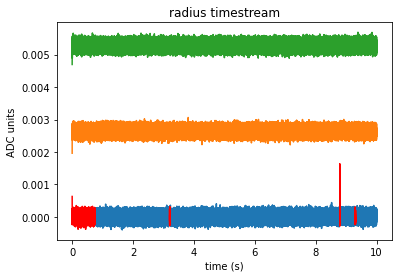

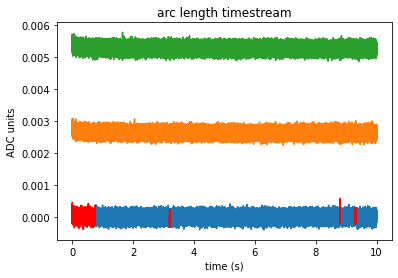

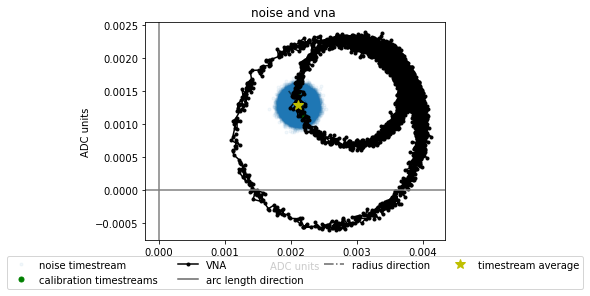

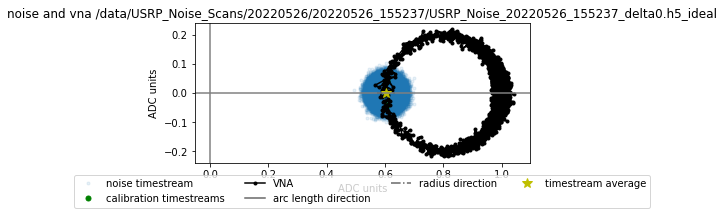

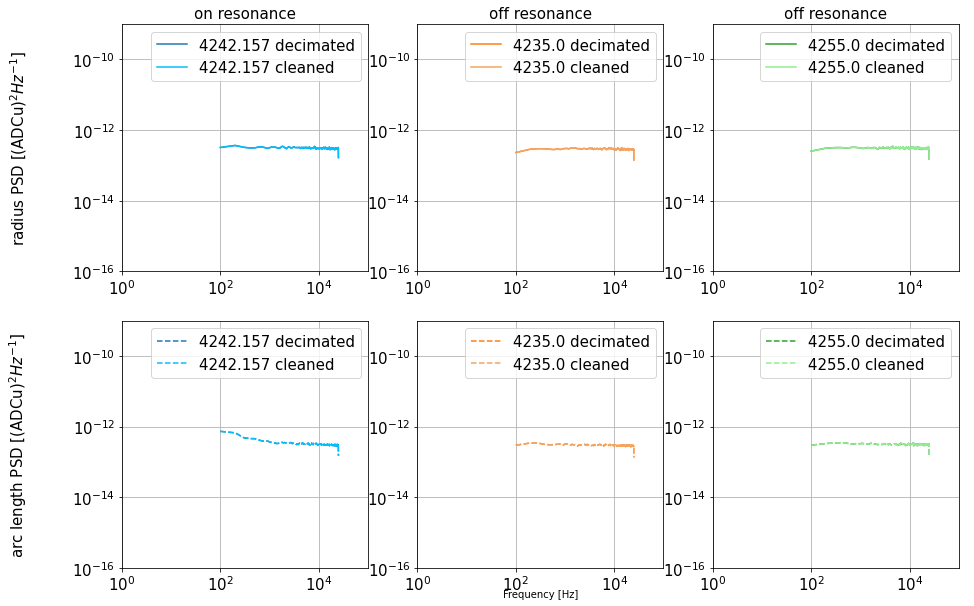

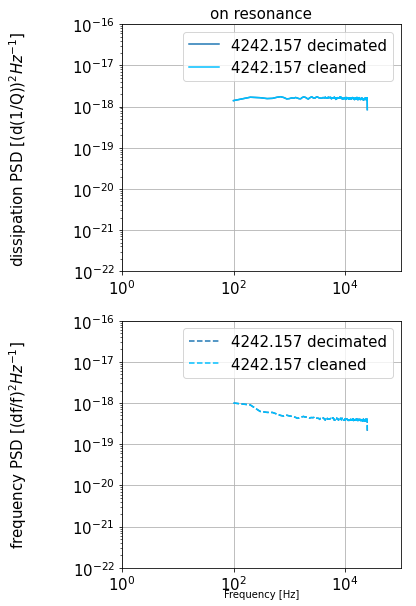

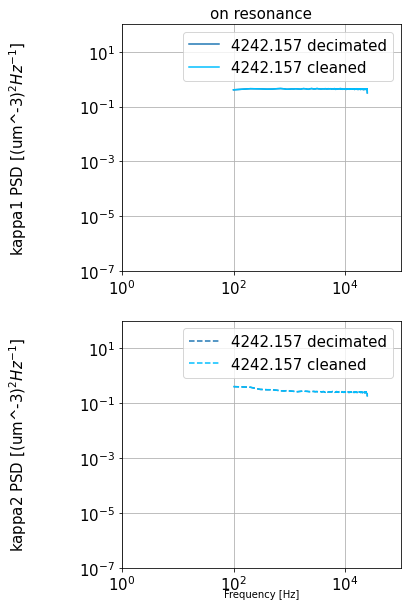

In [30]:
powers, PSDs, res, timestreams = CleanPSDs(tone_files[0], vna_file, f_transient=0.075,
                                           charFs = avg_frqs,
                                           charZs = avg_S21s,
                                           MBresults = MB_fit_vals)

In [ ]:
PSDs.keys()

In [ ]:
plt.loglog(PSDs['f'],PSDs['kappa_1'])

## Now package it all together

Line Delay file:  /data/USRP_Noise_Scans/20220526/20220526_153840/USRP_Delay_20220526_153840.h5
VNA scan file:    /data/USRP_Noise_Scans/20220526/20220526_153840/USRP_VNA_20220526_153840.h5
Timestream files: ['/data/USRP_Noise_Scans/20220526/20220526_153840/USRP_Noise_20220526_153840_delta0.h5']
Summary file:     /data/USRP_Noise_Scans/20220526/20220526_153840/noise_averages_20220526_153840.h5
Will separate data into  1000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
Will convert to quasiparticle basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20220526/20220526_153840/USRP_Noise_20220526_153840_delta0.h5 because override=True!
found 141 pulses
chunk length plugged into welch is 500


/home/nexus-admin/NEXUS_RF/AnalysisScripts/PyMKID_resolution_functions.py:862: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(noise_data_file + '_timestream')


Line Delay file:  /data/USRP_Noise_Scans/20220526/20220526_154322/USRP_Delay_20220526_154322.h5
VNA scan file:    /data/USRP_Noise_Scans/20220526/20220526_154322/USRP_VNA_20220526_154322.h5
Timestream files: ['/data/USRP_Noise_Scans/20220526/20220526_154322/USRP_Noise_20220526_154322_delta0.h5']
Summary file:     /data/USRP_Noise_Scans/20220526/20220526_154322/noise_averages_20220526_154322.h5
Will separate data into  1000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
Will convert to quasiparticle basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20220526/20220526_154322/USRP_Noise_20220526_154322_delta0.h5 because override=True!
found 5 pulses
chunk length plugged into welch is 500
ch

(1, 458000)
(1, 458000)
(2, 458000)
(1, 458000)
(1, 458000)
0.0005988243523873752
0.3747446975964783
saving clean_data to /data/USRP_Noise_Scans/20220526/20220526_155708/USRP_Noise_20220526_155708_delta0_cleaned.h5 because override=True!
number of chunks used to average is 916
Converting to resonator basis!
Converting to quasiparticle basis!
Line Delay file:  /data/USRP_Noise_Scans/20220526/20220526_155837/USRP_Delay_20220526_155837.h5
VNA scan file:    /data/USRP_Noise_Scans/20220526/20220526_155837/USRP_VNA_20220526_155837.h5
Timestream files: ['/data/USRP_Noise_Scans/20220526/20220526_155837/USRP_Noise_20220526_155837_delta0.h5']
Summary file:     /data/USRP_Noise_Scans/20220526/20220526_155837/noise_averages_20220526_155837.h5
Will separate data into  1000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
Will convert to quasiparticle basis!
d

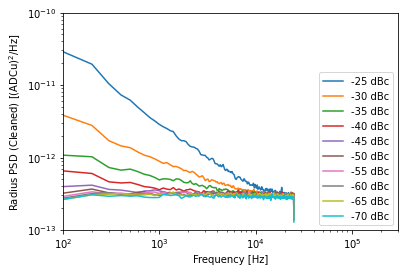

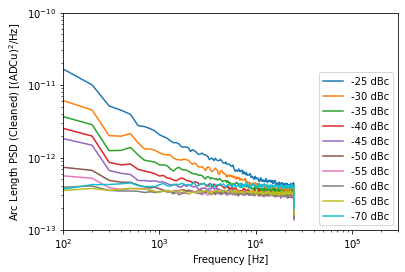

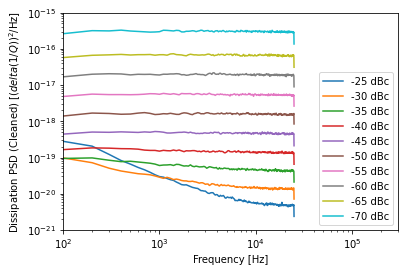

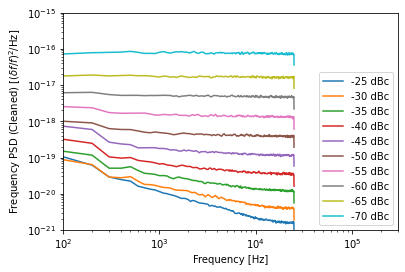

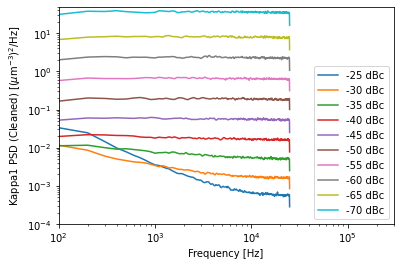

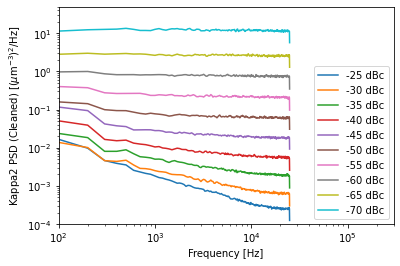

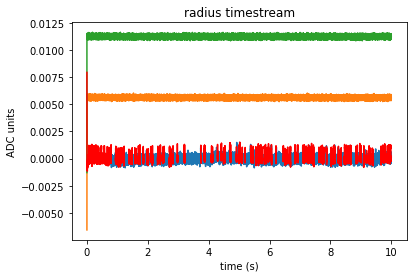

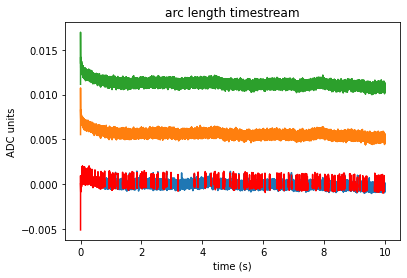

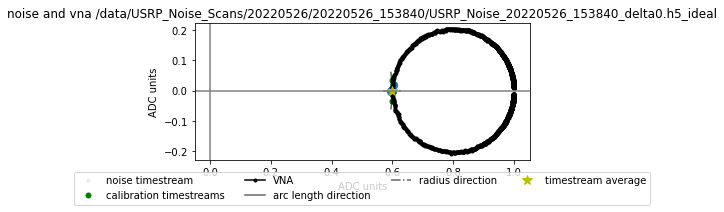

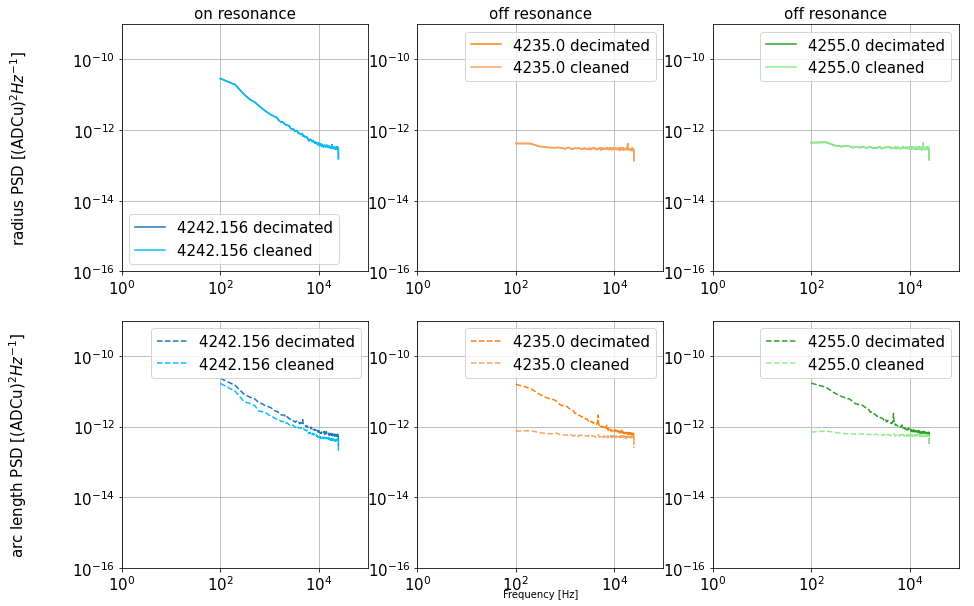

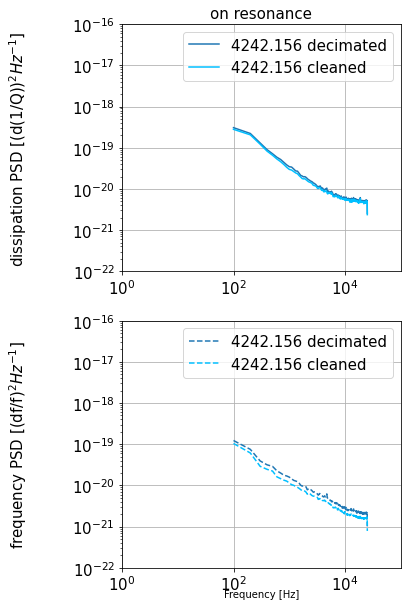

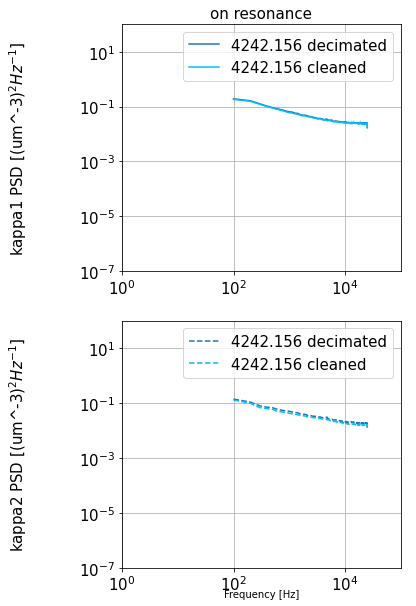

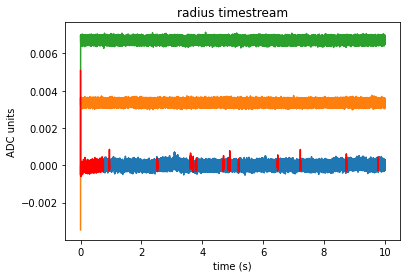

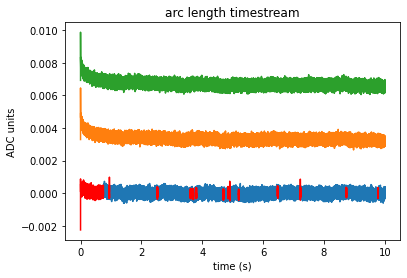

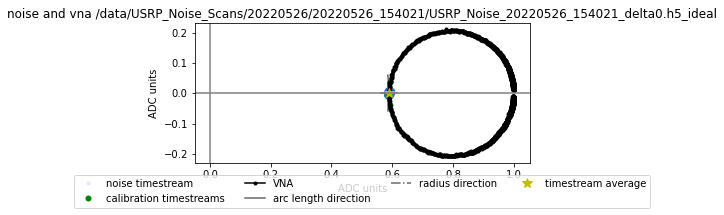

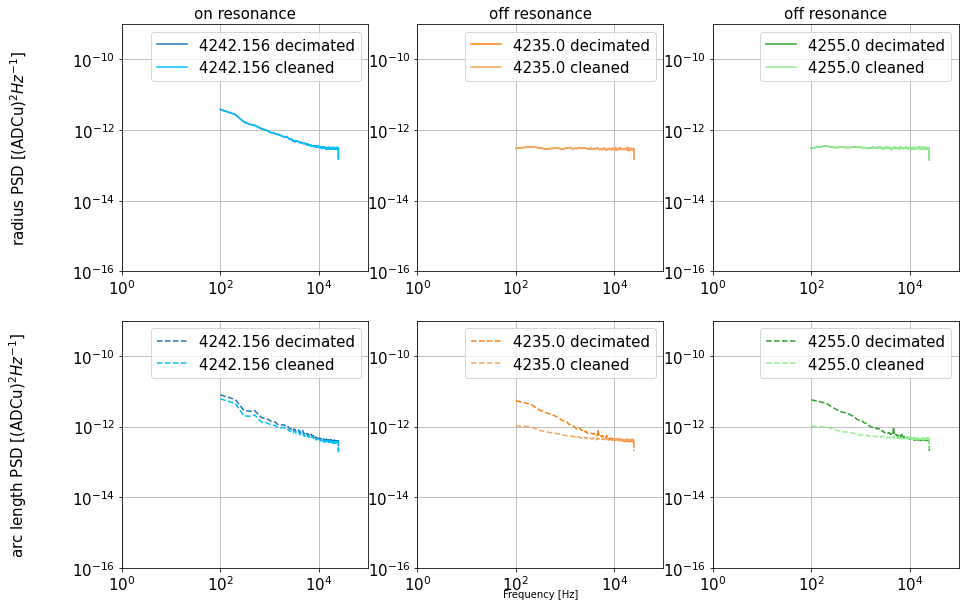

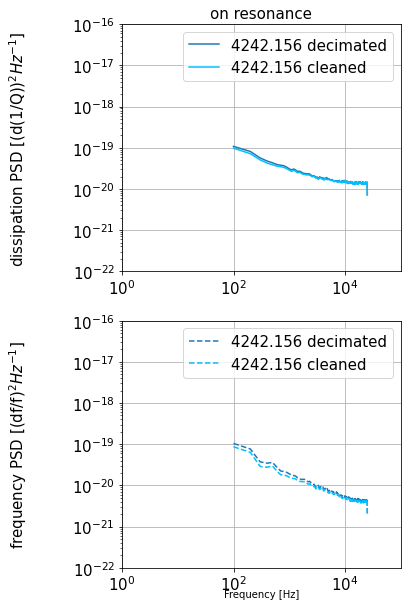

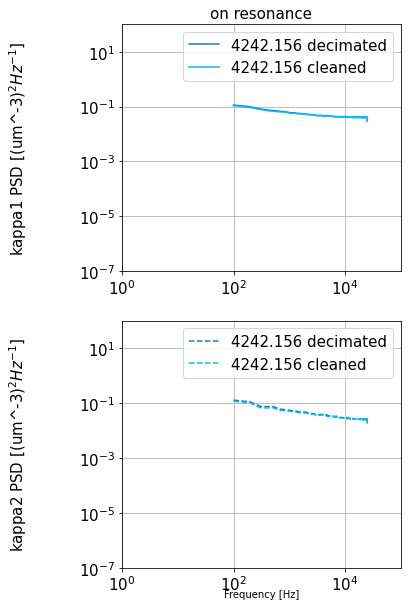

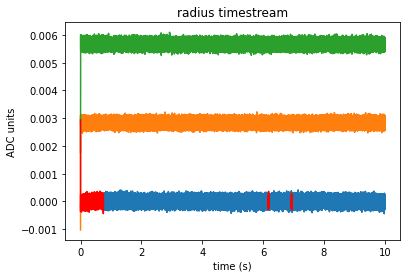

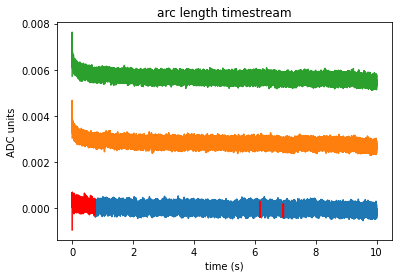

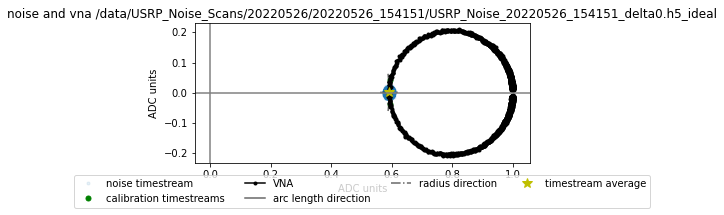

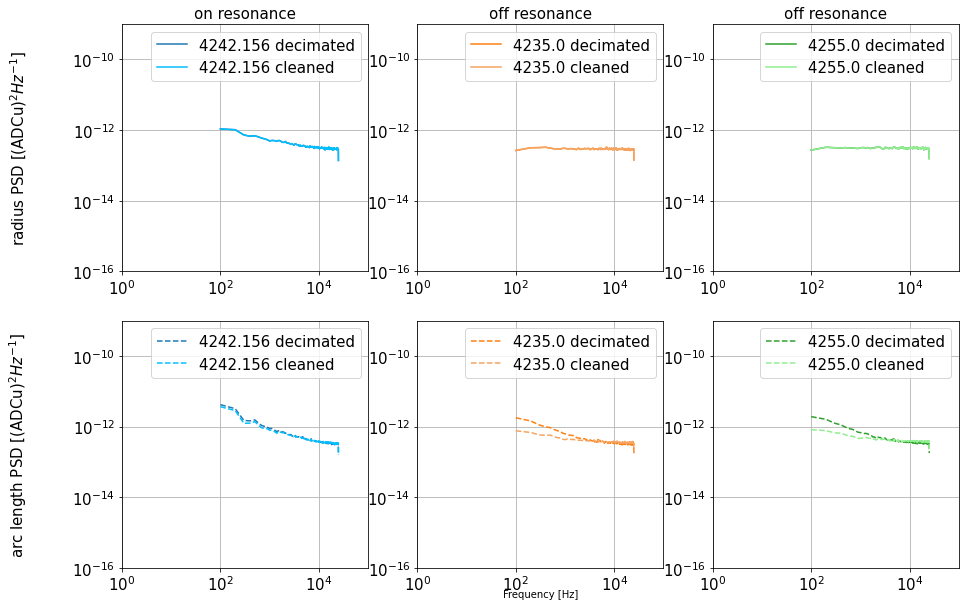

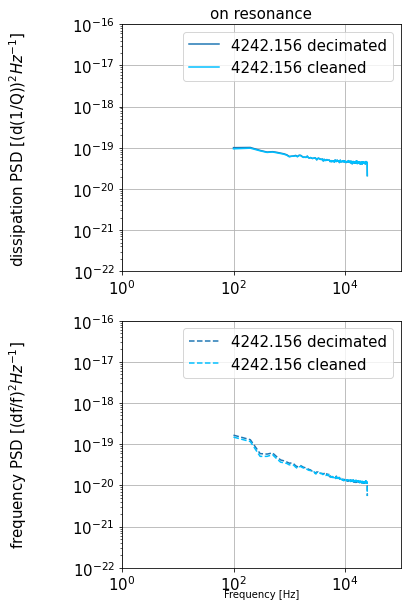

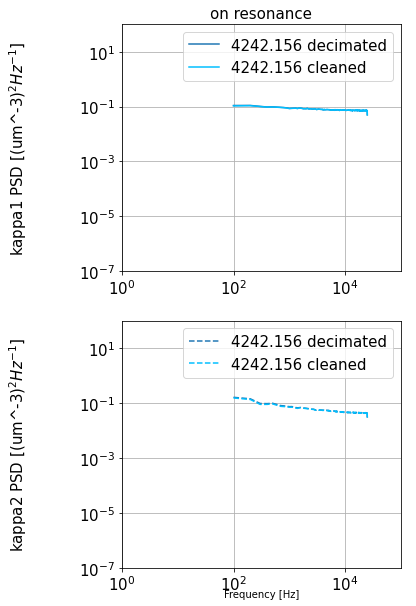

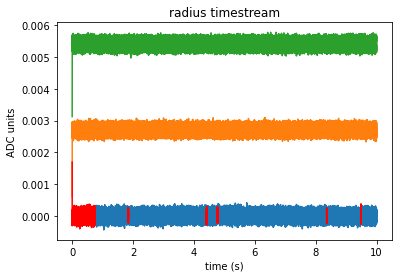

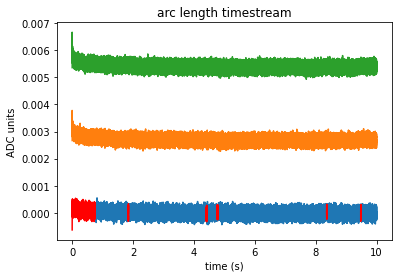

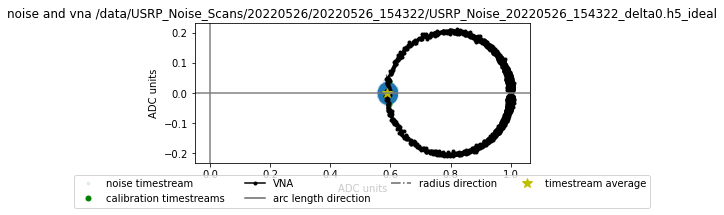

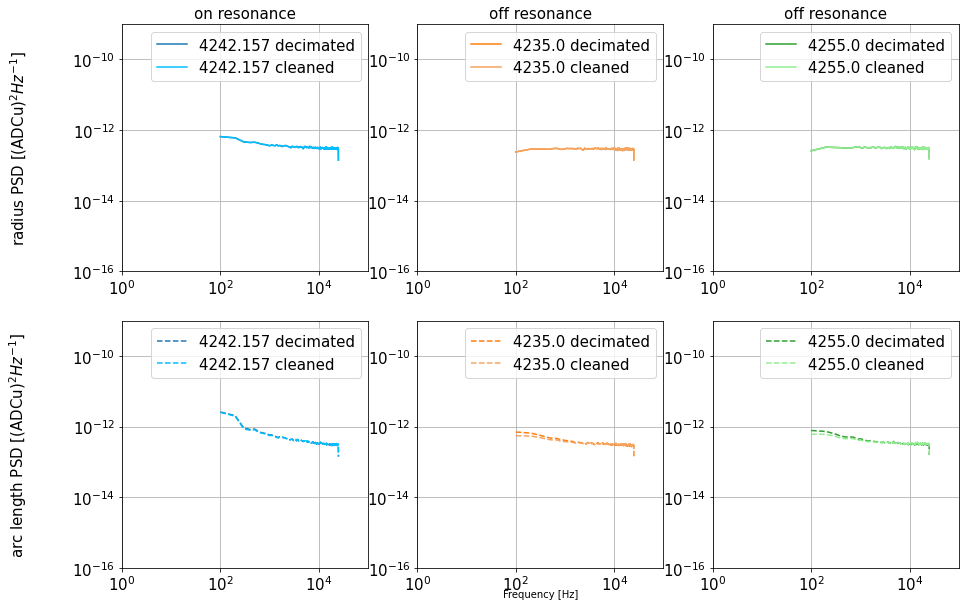

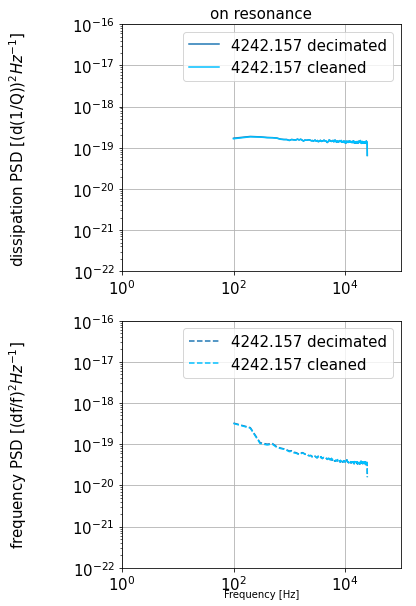

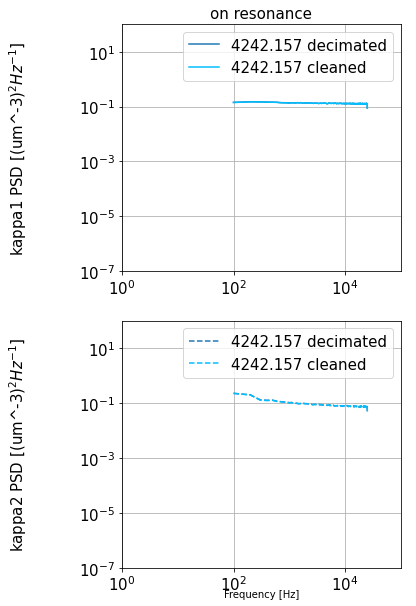

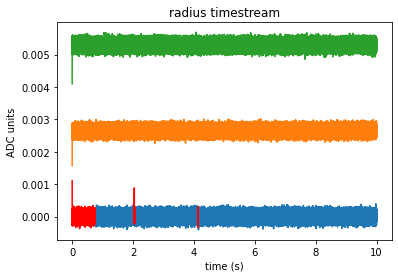

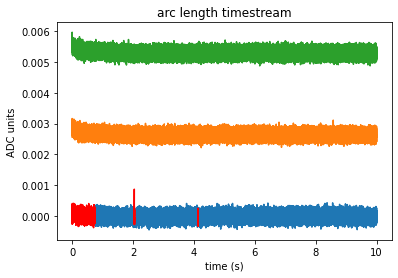

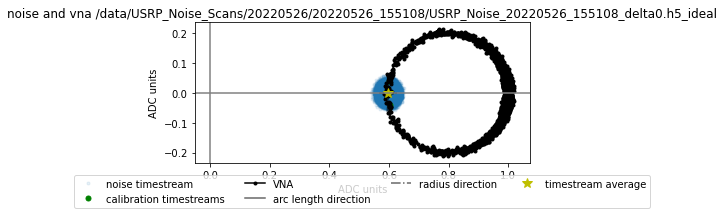

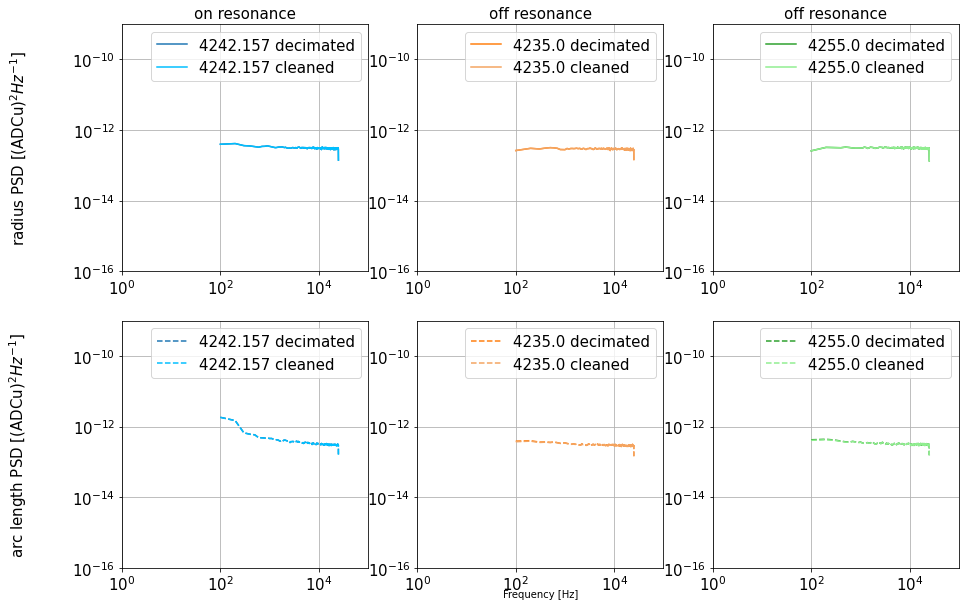

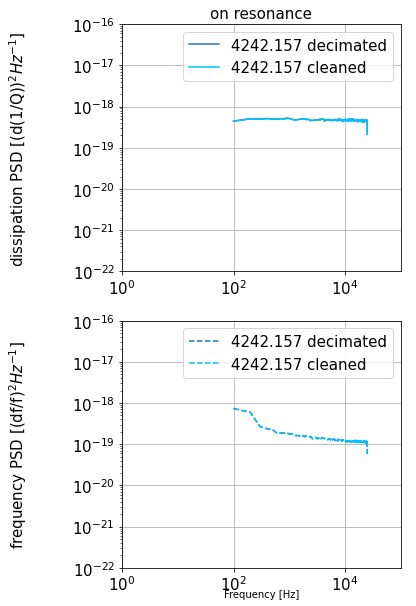

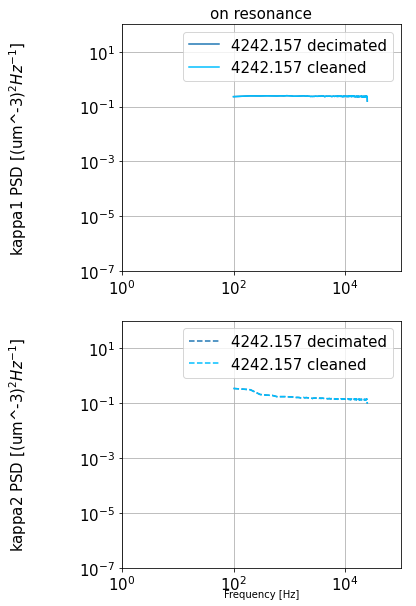

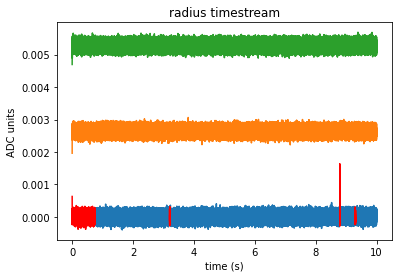

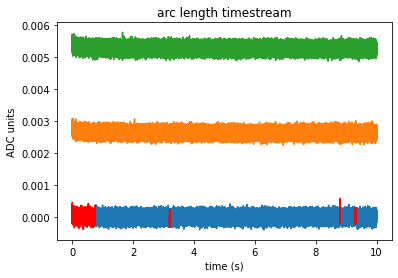

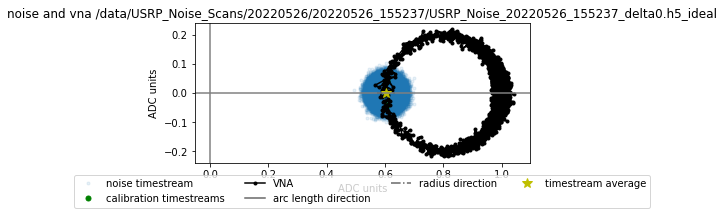

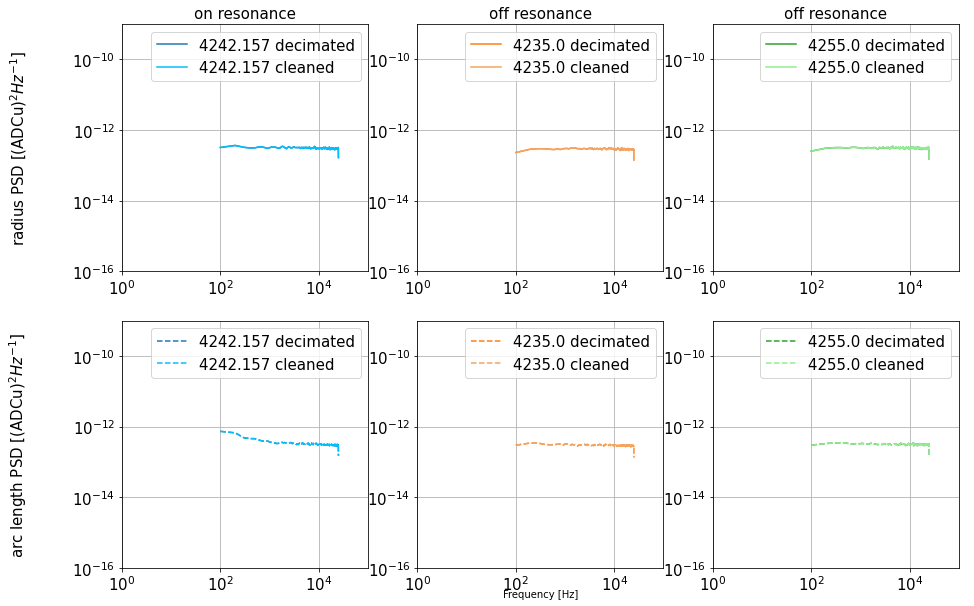

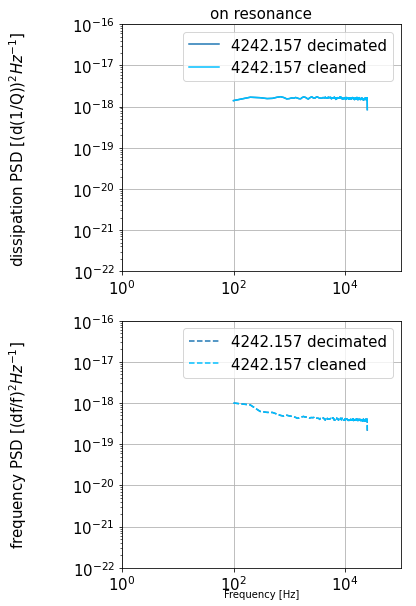

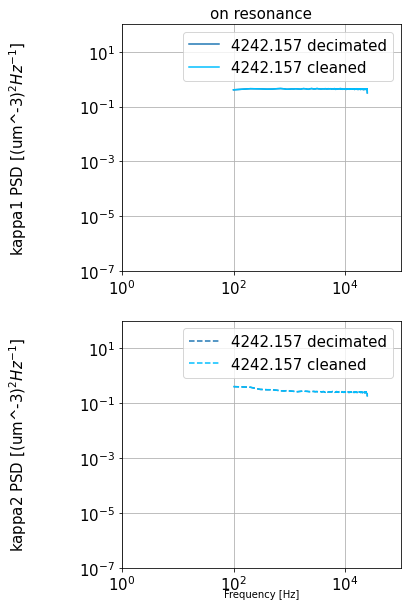

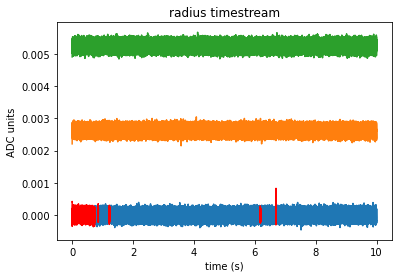

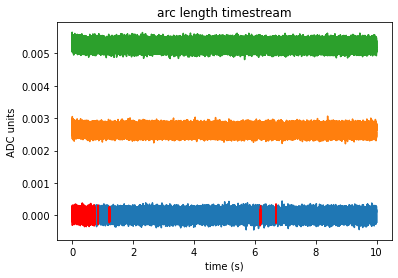

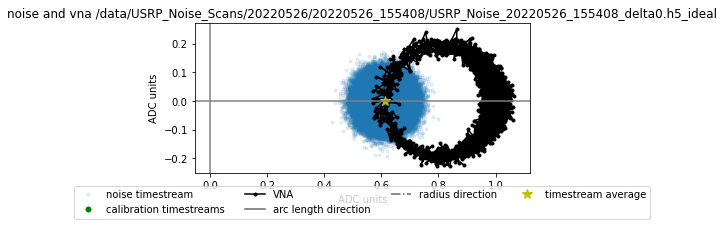

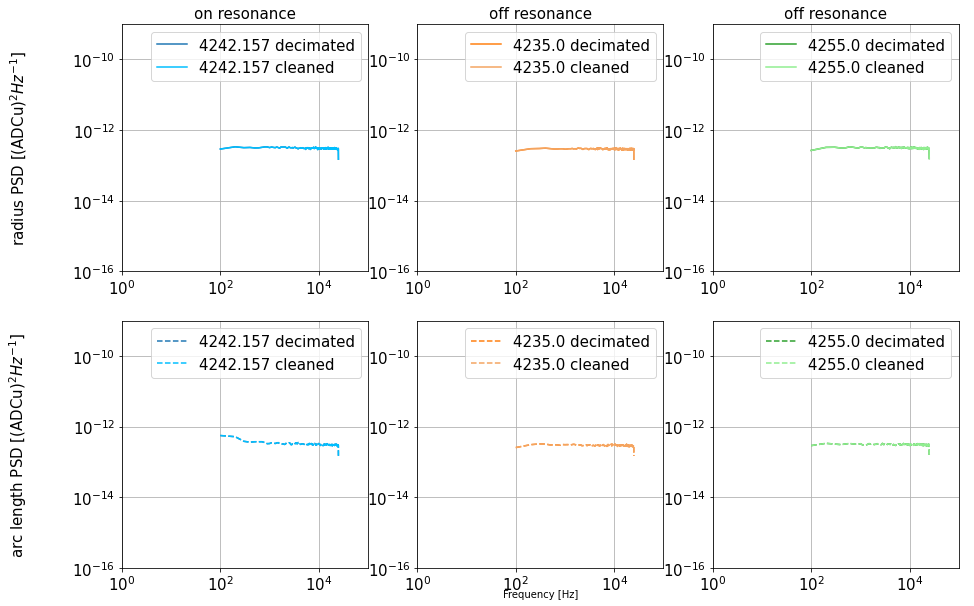

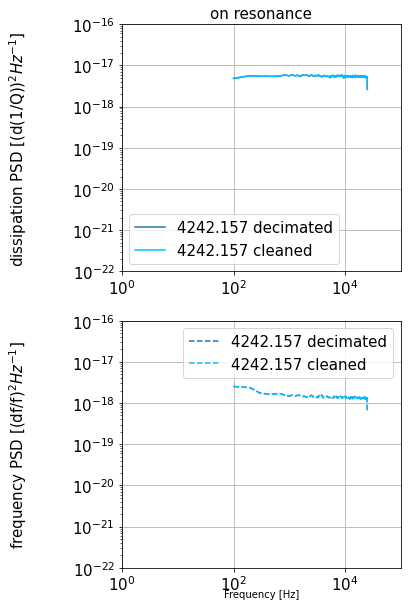

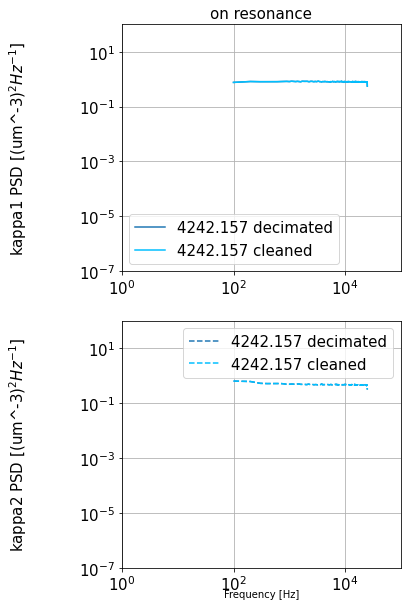

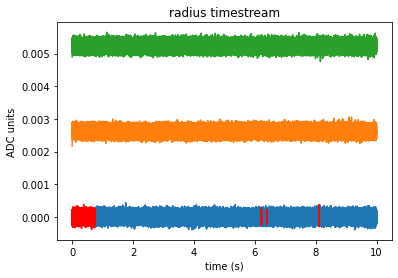

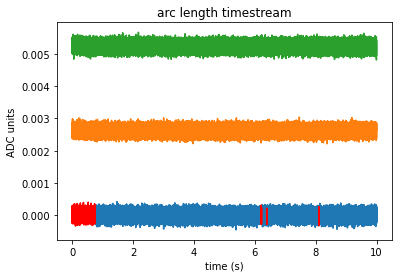

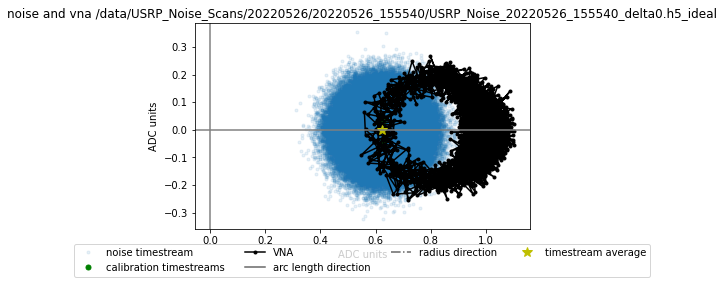

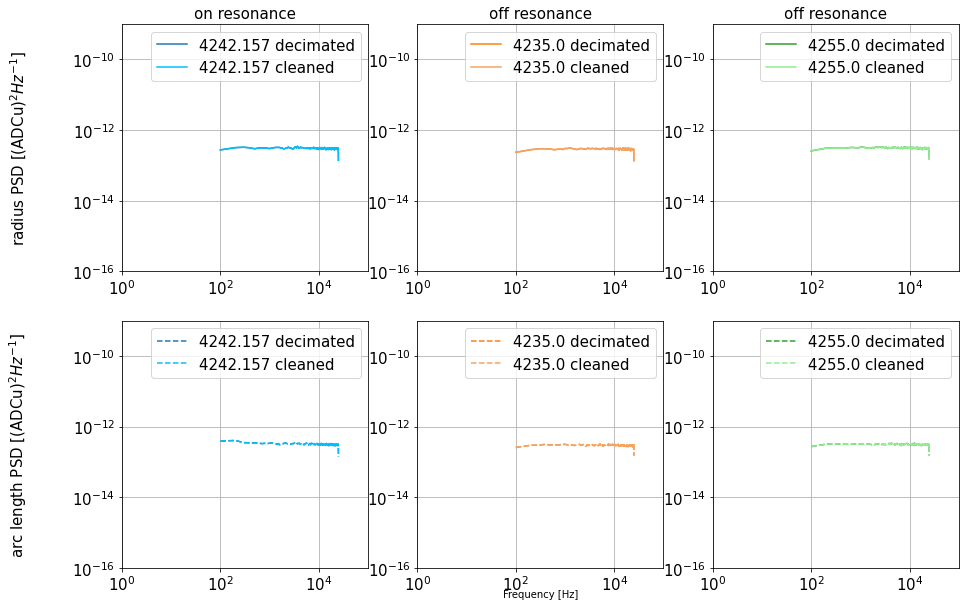

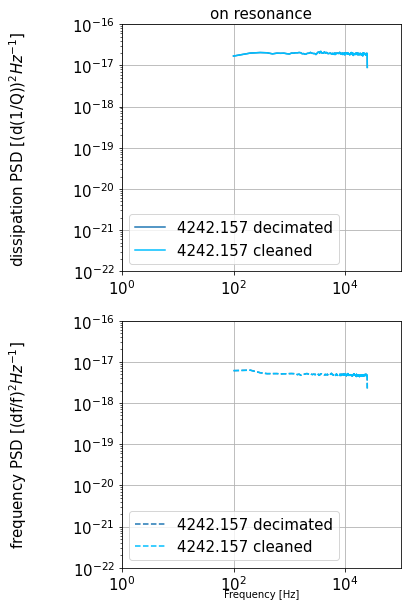

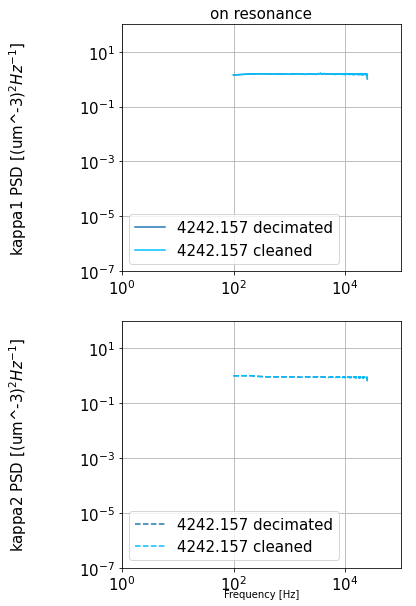

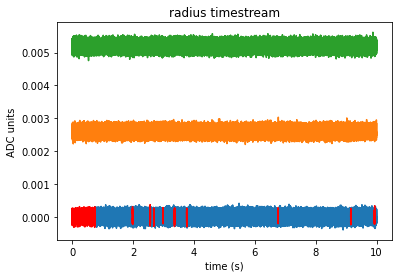

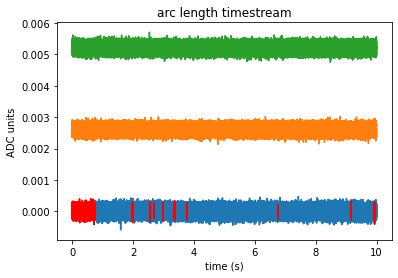

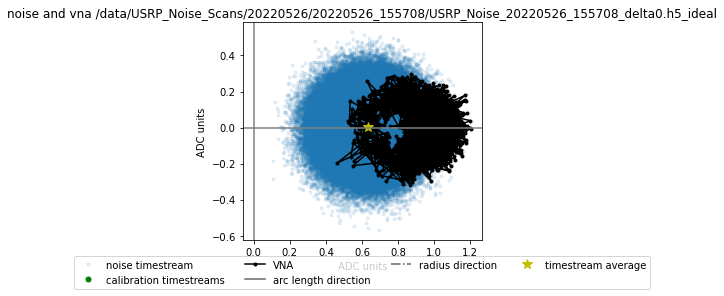

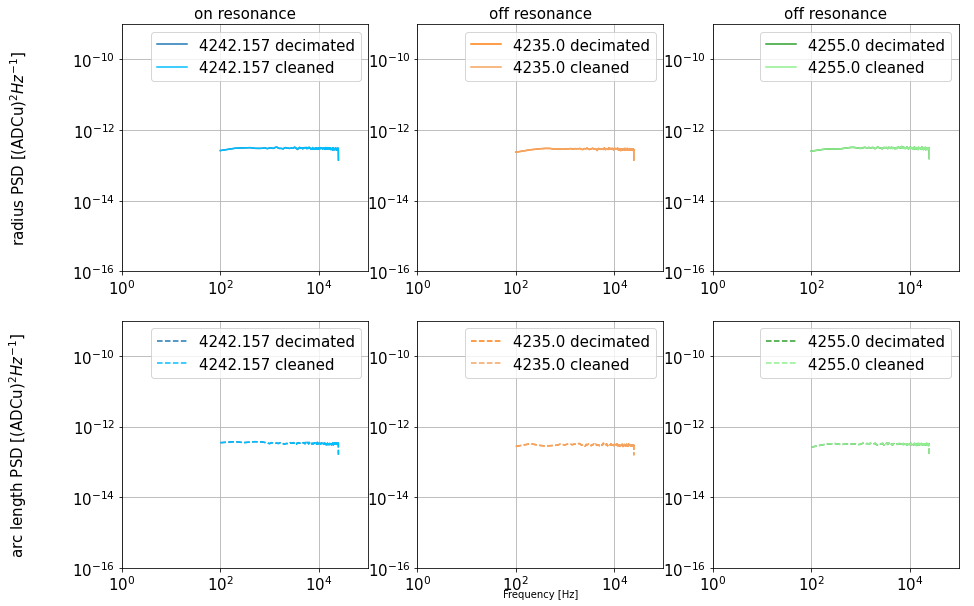

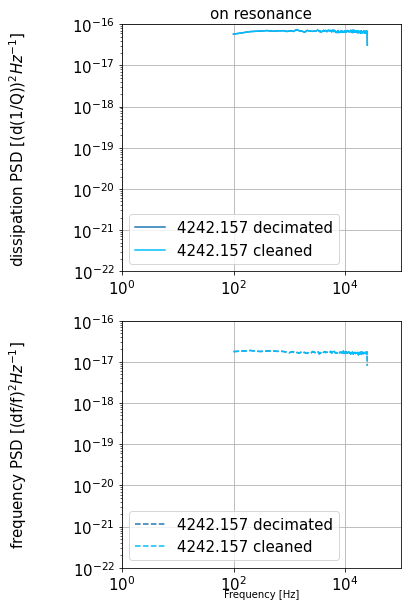

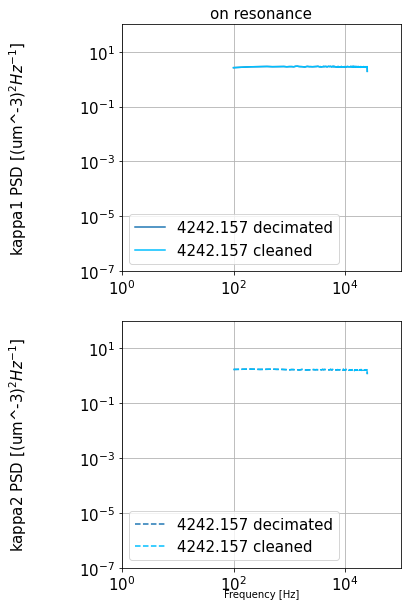

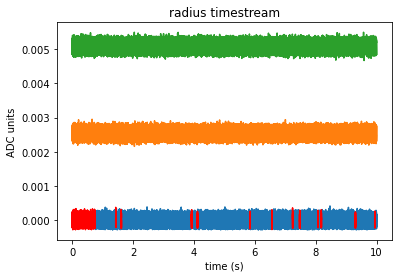

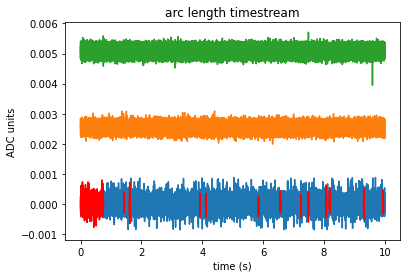

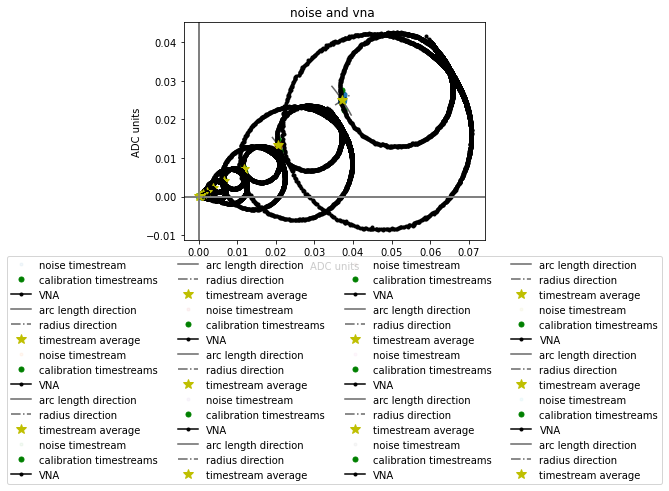

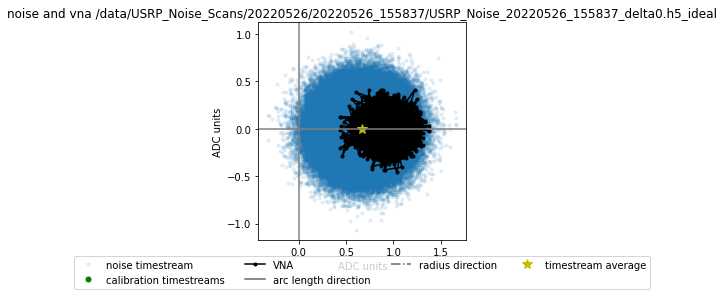

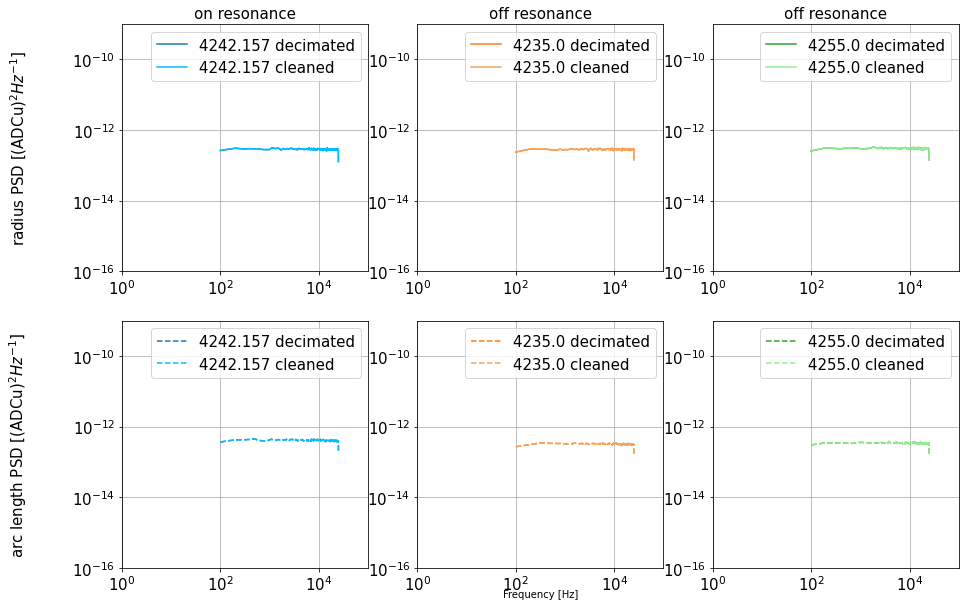

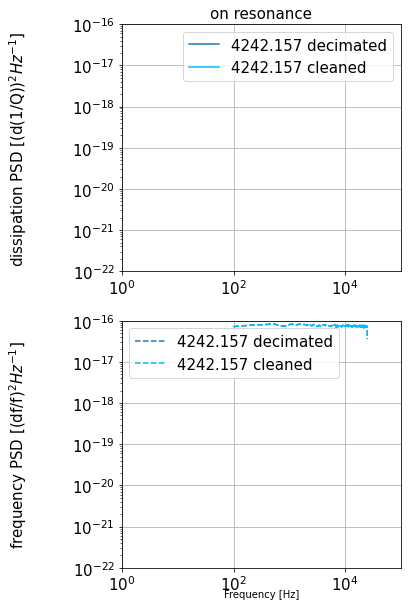

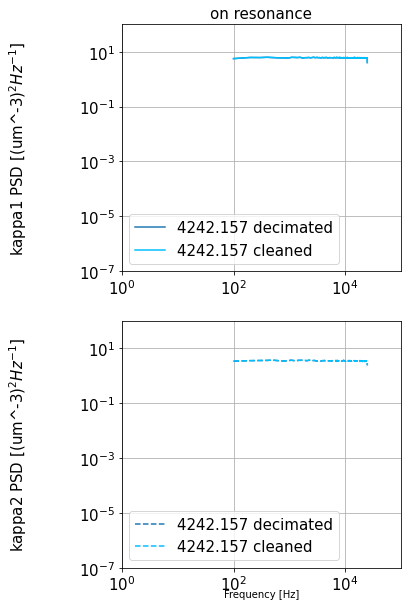

In [25]:
fHz_range = [1e2,3e5] ## Max F = 5e4 Hz
e_b_PSDrange = [1e-13,1e-10]
r_b_PSDrange = [1e-21,1e-15]
q_b_PSDrange = [1e-4,5e1]

## Create the axes
fga = plt.figure()
axa = fga.gca()

axa.set_xlabel("Frequency [Hz]")
axa.set_ylabel(r"Radius PSD (Cleaned) [(ADCu)$^2$/Hz]")
axa.set_xlim(fHz_range)
axa.set_ylim(e_b_PSDrange)
axa.set_xscale('log')
axa.set_yscale('log')

fgb = plt.figure()
axb = fgb.gca()

axb.set_xlabel("Frequency [Hz]")
axb.set_ylabel(r"Arc Length PSD (Cleaned) [(ADCu)$^2$/Hz]")
axb.set_xlim(fHz_range)
axb.set_ylim(e_b_PSDrange)
axb.set_xscale('log')
axb.set_yscale('log')


fgA = plt.figure()
axA = fgA.gca()

axA.set_xlabel("Frequency [Hz]")
axA.set_ylabel(r"Dissipation PSD (Cleaned) [$(delta(1/Q))^2$/Hz]")
axA.set_xlim(fHz_range)
axA.set_ylim(r_b_PSDrange)
axA.set_xscale('log')
axA.set_yscale('log')

fgB = plt.figure()
axB = fgB.gca()

axB.set_xlabel("Frequency [Hz]")
axB.set_ylabel(r"Frequency PSD (Cleaned) [$(\delta f/f)^2$/Hz]")
axB.set_xlim(fHz_range)
axB.set_ylim(r_b_PSDrange)
axB.set_xscale('log')
axB.set_yscale('log')

fg1 = plt.figure()
ax1 = fg1.gca()

ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel(r"Kappa1 PSD (Cleaned) [$(\mu$m$^{-3})^2$/Hz]")
ax1.set_xlim(fHz_range)
ax1.set_ylim(q_b_PSDrange)
ax1.set_xscale('log')
ax1.set_yscale('log')

fg2 = plt.figure()
ax2 = fg2.gca()

ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel(r"Kappa2 PSD (Cleaned) [$(\mu$m$^{-3})^2$/Hz]")
ax2.set_xlim(fHz_range)
ax2.set_ylim(q_b_PSDrange)
ax2.set_xscale('log')
ax2.set_yscale('log')

## Loop over every series
for i in np.arange(len(series_list)):
    sum_file, dly_file, vna_file, tone_files = GetFiles(series_list[i], verbose=True)
    
    metadata, avg_frqs, avg_S21s = UnpackSummary(sum_file)
    
    powers, PSDs, res, timestreams = CleanPSDs(tone_files[0], vna_file, f_transient=0.075,
                                           charFs = avg_frqs,
                                           charZs = avg_S21s,
                                           MBresults = MB_fit_vals)
    
    axa.plot(PSDs["f"],PSDs['radius'][:,0],label=str(powers_list[i])+" dBc")
    axb.plot(PSDs["f"],PSDs['arc'][:,0],label=str(powers_list[i])+" dBc")
    axA.plot(PSDs["f"],PSDs['dissipation'],label=str(powers_list[i])+" dBc")
    axB.plot(PSDs["f"],PSDs['frequency'],label=str(powers_list[i])+" dBc")
    ax1.plot(PSDs["f"],PSDs['kappa_1'],label=str(powers_list[i])+" dBc")
    ax2.plot(PSDs["f"],PSDs['kappa_2'],label=str(powers_list[i])+" dBc")
    
axa.legend(loc='lower right')
axb.legend(loc='lower right')
axA.legend(loc='lower right')
axB.legend(loc='lower right')
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')